In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import scipy


## Задание 1.



Теоретически найти оптимальное расстояние (имеющее минимальную оценку для суммарной ошибки) между точками, используемыми для вычисления производной. Сравнить фактическую ошибку с теоретической оценкой.

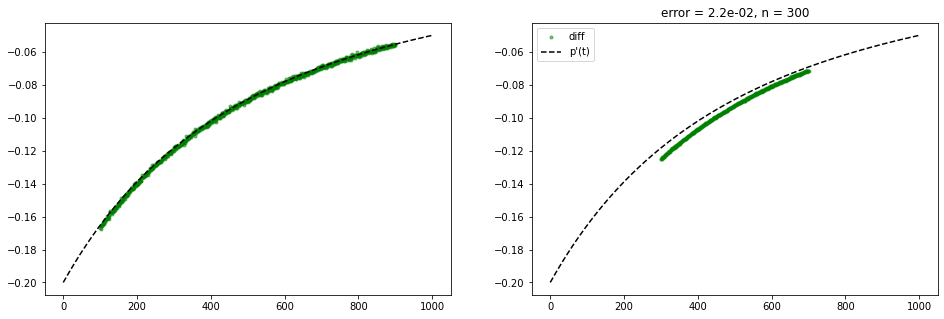

In [2]:
t = np.linspace(0, 1000, 1001)
p0 = 200
t0 = 1000

# Смоделируем измерения с погрешностью
p = p0 / (1 + t / t0) + 0.1 * np.random.randn(len(t))

# Истинное значение производной - для сравнения
pprime = -p0 / t0 / (1 + t / t0)**2; 

def diff20(t, p):
    return (p[20:] - p[:-20]) / (t[20:] - t[:-20])

def diff_n(t, p, n_):
    n = n_ * 2
    return (p[n:] - p[:-n]) / (t[n:] - t[:-n])

fig, axs = plt.subplots(1, 2, figsize=(16, 5))

n = 100
axs[0].plot(t[n:-n], diff_n(t, p, n), 'g.', alpha=0.5, label="diff")
axs[0].plot(t, pprime, 'k--', label="p'(t)")

n = 300
axs[1].plot(t[n:-n], diff_n(t, p, n), 'g.', alpha=0.5, label="diff")
axs[1].plot(t, pprime, 'k--', label="p'(t)")

plt.title('error = {:.1e}, n = {}'.format(np.abs(diff20(t, p) - pprime[10:-10]).max(), n))
plt.legend()
plt.show()

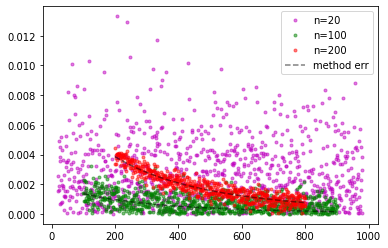

In [3]:
# Истинное значение третьей производной
dddp = - 6 * p0 / t0**3 / (1 + t / t0)**4; 

# раскладывая по Тейлору до o(n**3), находим ошибку связанную с методом:
def err_method(n): return np.abs(1 / 6 * n**2 * dddp[n:-n]);

# интересно посмотреть на ошибку при разных n
n = 20
err = np.abs(pprime[n:-n]-diff_n(t, p, n))
plt.plot(t[n:-n], err, 'm.', label="n={}".format(n), alpha=0.5)

n = 100
err = np.abs(pprime[n:-n]-diff_n(t, p, n))
plt.plot(t[n:-n], err, 'g.', label="n={}".format(n), alpha=0.5)
plt.plot(t[n:-n], err_method(n), 'k--', alpha=0.5)

n = 200
err = np.abs(pprime[n:-n]-diff_n(t, p, n))
plt.plot(t[n:-n], err, 'r.', label="n={}".format(n), alpha=0.5)
plt.plot(t[n:-n], err_method(n), 'k--', label="method err", alpha=0.5)

plt.legend()
plt.show()

Получается, что мы ищем минимум функции
$$
    F(n) = \frac{1}{6} n^2 p''' + \frac{\varepsilon}{n},
$$
которая минимизируется при
$$
    n_\text{opt}(t) = \sqrt[3]{\frac{3 \varepsilon}{p'''(t)}}.
$$
Построим получившийся график $n_\text{opt}(t)$.

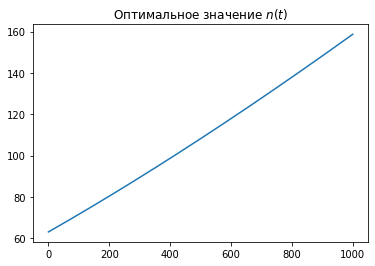

In [4]:
plt.plot(t, (3 * 0.1 / np.abs(dddp))**(1/3))
plt.title("Оптимальное значение $n(t)$")
plt.show()

## Задание 2. 



Прочитать документацию к [UnivariateSpline](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.UnivariateSpline.html) и определить оптимальное значение для параметра сглаживания **s**, учитывая, что шум был задан в виде $u_i = \dots + 0.5 \xi_i, \quad \xi_i \sim \mathcal N(0, 1)$. Экспериментально проверить оптимальность этого значения.

In [5]:
w0 = 0.04
u = p0 / (1 + t/t0) * (0.5 + 0.5 * np.cos(w0 * t)) + 0.5 * np.random.randn(len(t))
uprime = -p0*t0*(1 + np.cos(w0*t) + (t+t0)*w0*np.sin(w0*t))/(2*(t+t0)**2)

degs = list(range(0, 18))
errs = []
for deg in degs:
    _, [err], *_ =  np.polyfit(t, u, deg, full=True)
    errs.append(err)
    
U17 = np.poly1d(np.polyfit(t, u, deg=17))

In [6]:
from scipy.interpolate import UnivariateSpline, InterpolatedUnivariateSpline

In [7]:
Uint = InterpolatedUnivariateSpline(t, u, k=3)
Usmooth = UnivariateSpline(t, u, s=100)


def err_s(s):
    Usmooth = UnivariateSpline(t, u, w=np.ones(1001), s=s)
    err = np.abs(Usmooth.derivative()(t)-uprime)
    return np.mean(err)

ss = [5 * i for i in range(1, 100)];
errs = [err_s(s) for s in ss]




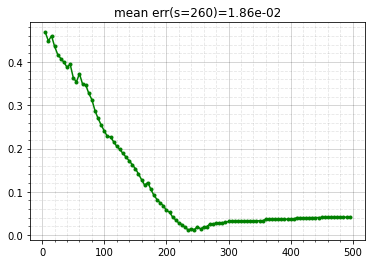

In [8]:
fig, ax = plt.subplots()
plt.plot(ss, errs, "g.-")
ax.minorticks_on()
ax.grid(b=True, which='major', color='k', linestyle='-', alpha=0.2)
ax.grid(b=True, which='minor', color='k', linestyle='--', alpha=0.1)
plt.title("mean err(s=260)={:.2e}".format(err_s(260)))
plt.show()

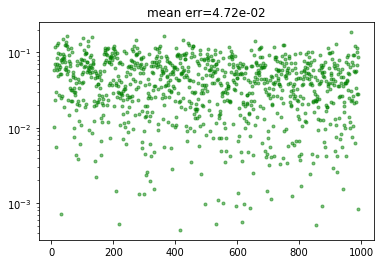

In [9]:
n = 9
err = np.abs(diff_n(t, u, n)-uprime[n:-n])
plt.semilogy(t[n:-n], err, "g.", alpha=0.5)

# plt.legend()
plt.title("mean err={:.2e}".format(np.mean(err)))
plt.show()

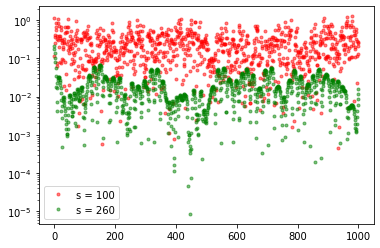

In [10]:
S = 100
Usmooth = UnivariateSpline(t, u, s=S)
err = np.abs(Usmooth.derivative()(t)-uprime)
plt.semilogy(t, err, "r.", alpha=0.5, label="s = {}".format(S))

S = 260
Usmooth = UnivariateSpline(t, u, s=S)
err = np.abs(Usmooth.derivative()(t)-uprime)
plt.semilogy(t, err, "g.", alpha=0.5, label="s = {}".format(S))

plt.legend()
plt.show()

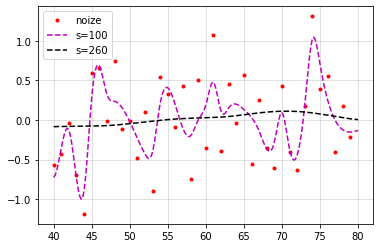

In [11]:
s1 = 100
s2 = 260
u_clean = p0 / (1 + t/t0) * (0.5 + 0.5 * np.cos(w0 * t))

Usmooth1= UnivariateSpline(t, u, s=s1)
Usmooth2= UnivariateSpline(t, u, s=s2)

start = 40;
end   = 80;
t_s2e = np.linspace(start, end, 200)
u_clean2 = p0 / (1 + t_s2e/t0) * (0.5 + 0.5 * np.cos(w0 * t_s2e))

plt.plot(t[start:end], u[start:end]-u_clean[start:end], "r.", label="noize")
plt.plot(t_s2e, Usmooth1(t_s2e)-u_clean2, "m--", label='s=100')
plt.plot(t_s2e, Usmooth2(t_s2e)-u_clean2, "k--", label='s=260')
plt.grid(alpha=0.5)
plt.legend()
plt.show()

Тогда можем оценить s_opt разложив по Тейлору u. Будем считать ошибку метода $\approx u^{(4)}/4! \cdot k^4$, где $k$ -- количество узлов. Можем посчитать и  найти
$$
    \langle |u^{(4)}/4!| \rangle \approx 5 \cdot 10^{-6}.
$$
Знаем, что можем получить ошибку $\delta_\text{min}\sim 10^{-2}$, а значит, $k_\text{opt} \approx \varepsilon/\delta_\text{min} \approx 25$. С учётом  smooth condition, находим
$$
    s \sim k_\text{opt}  (u^{(4)}/4! \cdot k_\text{opt}^4 + \varepsilon)^2 \sim 200,
$$
что сходится по порядку с $s_\text{opt} = 260$. 

### Задание 3.

Жёсткопоршневый излучатель звука вмонтирован в стену - бесконечную перегородку (смотри рисунок). 

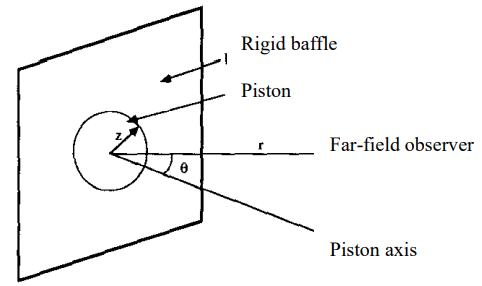  

Вибрирующий поршень может представлять собой либо вибрирующую поверхность, либо вибрирующий слой воздуха. Основное предположение в анализе такого излучателя (которое на практике не является строго правильным для реальных поверхностей) в том, что все части поршня колеблются в фазе и с одинаковой амплитудой. 

Актуальность этой задачи в инженерной шумоизоляции заключается в том, что она служит базовой моделью для исследования звукового излучения от
различных типы поверхностей, напр. колонки; открытые концы фланцевых труб, пластин и ракушки и т.д.

Рассмотрим плоский круглый поршень радиуса z, установленный в бесконечной жесткой перегородке.
как показано на рисунке выше. Шум, излучаемый вибрирующим поршнем, можно смоделировать в с точки зрения многочисленных точечных монополей (монополей, где ka <1), излучающих вместе. Каждый из монополь, однако, излучается от жесткой отражающей поверхности. Таким образом, звуковое давление, создаваемое любым из монополей с перегородкой, в два раза больше давления от эквивалентного монополя в свободном пространстве.

Подробное решение этой задачи найти в лекциях и учебниках по акустике и теории звука, на эту тему с поиском асимптотик и разбором частных случаев пишут много статей, например,  **THE STUDY OF A VIBRATING PISTON MOUNTED IN A RIGID BAFFLE ANNALS of the ORADEA UNIVERSITY (
Fascicle of Management and Technological Engineering, Volume VII (XVII), 2008)**.

Радиационный импеданс поршня можно получить, интегрируя
распределение давления по площади поверхности поршня для получения общего звукового давления в точке, и затем снова интегрируя это по поверхности, чтобы получить силу Fp.  В результате появляются 
функции Струве https://mathworld.wolfram.com/StruveFunction.html . Функции Струве также часто возникают в задачах оптики, дифракции, электродинамики. 

На практике, разумеется, не вызывают каждый раз эти функции с помощью, например, Wolfram, так как их вычисления занимают много времени. Вместо этого используют расчётные графики и таблицы по акустике, а значения функций и их производных в промежуточных точках вычисляют с помощью интерполяции и формул численного дифференцирования. Кроме того, в этих таблицах обычно протабулированные функции Струве и Бесселя соединяются с какими-то экспериментальными данными, так как в этой науке далеко не все коэффициенты можно посчитать из базовых уравнений.



Вычислить производную функцию Струве 0-го индекса $H_{0}(x)$ в точке $x=7,5$, если $H_{0}(x)$ задана таблицей:

$$
\begin{array}{|c|c|c|c|c|c|c|c|}
\hline x & y & \Delta^{1} y & \Delta^{2} y & \Delta^{3} y & \Delta^{4} y & \Delta^{5} y & \Delta^{6} y \\
\hline 7,50 & 0,2009 & 49 & 0 & -1 & 1 & 0 & -3 \\
\hline 7,52 & 0,2058 & 49 & -1 & 0 & 1 & -3 & 7 \\
\hline 7,54 & 0,2107 & 48 & -1 & 1 & -2 & 4 & -9 \\
\hline 7,56 & 0,2155 & 47 & 0 & -1 & 2 & -5 & \\
\hline 7,58 & 0,2202 & 47 & -1 & 1 & -3 & & \\
\hline 7,60 & 0,2249 & 46 & 0 & 2 & & & \\
\hline 7,62 & 0,2295 & 46 & -2 & & & & \\
\hline 7,64 & 0,2341 & 44 & & & & & \\
\hline 7,66 & 0,2385 & & & & & & \\
\hline
\end{array}
$$

Здесь шаг $h=0,02$ и все числа в конечных разностях $\Delta^{1} y, \Delta^{2} y, \ldots$ надо умножить на $10^{-4}$.

Оценивая погрешность метода (усечения) как
$$
\frac{1}{3 h} \max \left|\Delta^{3} y\right| 
$$

показать, что она меньше погрешности, возникающей из-за округления.

Погрешность чисел в таблице считать равной половине единицы разряда последней значащей цифры.


Так как шаг $h=0.02$ постоянный нетрудно найти коэффицинты разложения при разных $n$:
$$
\begin{array}{|c|ccccccccc|}
\hline
n &\alpha_1&\alpha_2&\alpha_3&\alpha_4&\alpha_5&\alpha_6&\alpha_7&\alpha_8&\alpha_9\\
\hline
 4&-91.6667 & 150. & -75. & 16.6667 &&&&&\\
  5&-104.167 & 200. & -150. & 66.6667 & -12.5 &&&&\\
 6&-114.167 & 250. & -250. & 166.667 & -62.5 & 10. &&&\\ 
7&-122.087 & 297.521 & -368.802 & 325.069 & -181.302 & 57.5207 & -7.92011 &&\\
 8&-127.833 & 337.802 & -489.812 & 527.033 & -383.546 & 179.035 & -48.4808 & 5.80237 &\\
 9&-135.305 & 397.98 & -701.773 & 953.462 & -919.506 & 609.977 & -264.955 & 67.9147 & -7.79389 \\
 \hline
\end{array}
$$

Которые мы находим, как решение системы описанной на лекции C1. Тогда полученные значения производной и их ошибка:
$$
\begin{array}{|c|c|}
\hline
n &f'-f_\text{true}' \\
\hline
3 & 3.1\times 10^{-5}\\
4 & 3.6\times 10^{-7}\\ 
5 & -6.2\times 10^{-9}\\ 
6 & -1.0\times 10^{-10}\\ 
7 & -3.8\times 10^{-12}\\ 
8 & -5.6\times 10^{-12}\\ 
9 & -6.2\times 10^{-12}\\ 
 \hline
\end{array}
$$
где $f_\text{true}' = 0.24830669236337624$.

### Задание 4.

Возьмите данные с шумом из первых двух заданий. Постройте график производной: 

1) с помощью кубического сплайна, без сглаживания данных

2) с помощью кубического сплайна, после сглаживания данных (как в задании 2).

Постройте графики для сравнения результатов. 

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

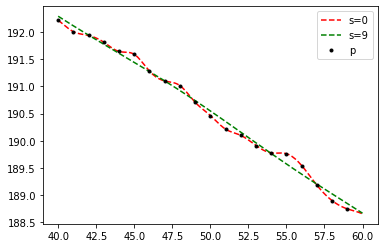

In [13]:
t = np.linspace(0, 1000, 1001)
p0 = 200
t0 = 1000

p = p0 / (1 + t / t0) + 0.1 * np.random.randn(len(t))
pprime = -p0 / t0 / (1 + t / t0)**2; 

w0 = 0.04
u = p0 / (1 + t/t0) * (0.5 + 0.5 * np.cos(w0 * t)) + 0.5 * np.random.randn(len(t))
uprime = -p0*t0*(1 + np.cos(w0*t) + (t+t0)*w0*np.sin(w0*t))/(2*(t+t0)**2)

start = 40;
end   = 60;

tck_p = interpolate.splrep(t, p, s=0)
t_lin = np.linspace(start, end, 200)
p_spline = interpolate.splev(t_lin, tck_p, der=0)
plt.plot(t_lin, p_spline, "r--", label="s=0")

tck_p = interpolate.splrep(t, p, s=9)
t_lin = np.linspace(start, end, 200)
p_spline = interpolate.splev(t_lin, tck_p, der=0)
plt.plot(t_lin, p_spline, "g--", label="s=9")


plt.plot(t[start:end], p[start:end], "k.", label="p")
plt.legend()
plt.show()

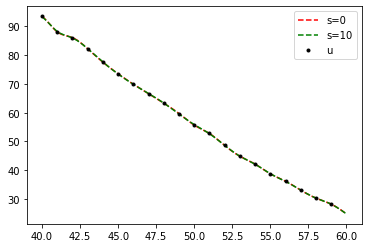

In [14]:
tck_u = interpolate.splrep(t, u, s=0)
t_lin = np.linspace(start, end, 200)
u_spline = interpolate.splev(t_lin, tck_u, der=0)
plt.plot(t_lin, u_spline, "r--", label="s=0")

tck_u = interpolate.splrep(t, u, s=10)
t_lin = np.linspace(start, end, 200)
u_spline = interpolate.splev(t_lin, tck_u, der=0)
plt.plot(t_lin, u_spline, "g--", label="s=10")


plt.plot(t[start:end], u[start:end], "k.", label="u")
plt.legend()
plt.show()

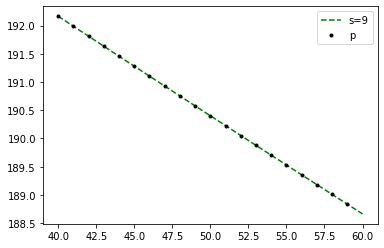

In [15]:
p_smooth = UnivariateSpline(t, p, w=np.ones(1001), s=260)
tck_p = interpolate.splrep(t, p_smooth(t), s=9)
t_lin = np.linspace(start, end, 200)
p_spline = interpolate.splev(t_lin, tck_p, der=0)
plt.plot(t_lin, p_spline, "g--", label="s=9")


plt.plot(t[start:end], p_smooth(t)[start:end], "k.", label="p")
plt.legend()
plt.show()

In [ ]:
plt.plot(t_lin, p_spline-p_smooth(t_lin), "g.")
plt.title("Разница")
plt.show()

# Задание 5.

При дифференцировании функций имеются два основных источника погрешности

- Ошибка метода - уменьшается при уменьшении $\boldsymbol{h}$

- Ошибка вычислений - растет при уменьшении $\boldsymbol{h}$


Поскольку характер роста ошибок различный, существует некоторое значение $h^{*}$, при котором ошибка минимальна. Рассмотрите полную ошибку
$\varepsilon_{\text {total }}=\varepsilon_{\text {method }}+\varepsilon_{\text {comp }}$
как функцию от $h$ для формулы центральной разности и найдите минимум. 

$$
f^{\prime}\left(x_{0}\right) \approx \frac{1}{12 h}\left(f_{i-2}-8 f_{i-1}+8 f_{i+1}-f_{i+2}\right)
$$


Максимум модуля пятой  производной в окрестности $x_{0}$ оценивайте как $M_{5}$, ошибку вычисления $f$ как $\Delta f$.

Раскладывая по Тейлору
$$
    \frac{1}{12h}(f(x_0-2h) - 8 f(x_0 -h) + 8 f(x_0 + h) - f(x_0 + 2h)) \approx f'(x_0) - \frac{2}{5} f^{(5)} h^5 + o(h^5).
$$
приходим к оптимизации выражения, вида
$$
    F = \frac{2}{5} M_5 h^5 + \frac{3 \varepsilon}{2 h},
$$
которое оптимизируется при
$$
    h_\text{opt} = \sqrt[5]{\frac{3 \varepsilon}{4 M_5}},
$$
где $\varepsilon = \Delta f$ из условия.

# Задание 6.

Используя сглаженные данные из задания 2, постройте график производной с помощью формулы из задания 5. Сравнить фактическую ошибку вычисления производной с теоретической оценкой из задания 5. Также сравнить, используя для вычисления производной не соседние точки, а точки на расстоянии, определённом из задания 1.

In [ ]:
t = np.linspace(0, 1000, 1001)
p0 = 200
t0 = 1000

# Смоделируем измерения с погрешностью
p = p0 / (1 + t / t0) + 0.1 * np.random.randn(len(t))

M5 = 2.4e-11
eps = 0.1
h_opt = np.int32((3 * eps / (4 * M5))**(0.2))

print("h_opt = ", h_opt)

dp5 = (p[:-4*h_opt] - 8 * p[h_opt:-3*h_opt] + 8 * p[3*h_opt:-h_opt] - p[4*h_opt:])/12/h_opt
plt.plot(t[2*h_opt:-2*h_opt], np.abs(pprime[2*h_opt:-2*h_opt]-dp5), "g.", alpha=0.5, label="$o(h^5)$")

n = 100
err = np.abs(pprime[n:-n]-diff_n(t, p, n))
plt.plot(t[n:-n], err, 'r.', label="n={}".format(n), alpha=0.5)
plt.plot(t[n:-n], err_method(n), 'k--', alpha=1, label="$o(h^3)$")

plt.plot(t, t*0+3 * 0.1 / h_opt / 2 * 1.2, label="theory")

plt.legend()
plt.show()

print(np.mean(np.abs(pprime[2*h_opt:-2*h_opt]-dp5)),np.mean(err))